# Find connected subcomponents; explore them

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data.load_dataset import load_epacems, load_epa_crosswalk
from src.features.build_features import uptime_events, calc_distance_from_downtime, make_subcomponent_ids, aggregate_subcomponents
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
pd.options.display.max_columns = 50

## CEMS Processing

In [4]:
# all states, 1 year
cols = ['plant_id_eia', 'unitid', 'operating_datetime_utc',
        'operating_time_hours', 'gross_load_mw', 'steam_load_1000_lbs',
        'heat_content_mmbtu', 'unit_id_epa',
       ]
cems = load_epacems(states=None, years=[2019], columns=cols, engine='pandas')

In [5]:
%%time
idx = pd.IndexSlice
cems.sort_values(by=['unit_id_epa', 'operating_datetime_utc'], inplace=True)
cems.set_index(['unit_id_epa', 'operating_datetime_utc'], drop=False, inplace=True)#, verify_integrity=True)

CPU times: user 15.7 s, sys: 4.23 s, total: 19.9 s
Wall time: 20.2 s


## Crosswalk Processing

In [6]:
crosswalk = load_epa_crosswalk()

In [7]:
crosswalk.shape

(6930, 33)

### Filter out inappropriate records

In [8]:
xwalk = crosswalk[~crosswalk['MATCH_TYPE_GEN'].isin({'CAMD Unmatched', 'Manual CAMD Excluded'})].copy()
xwalk.shape

(6407, 33)

In [9]:
subset = ['CAMD_FACILITY_NAME', 'CAMD_PLANT_ID', 'CAMD_UNIT_ID', 'CAMD_GENERATOR_ID',
          'EIA_PLANT_NAME', 'EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'EIA_BOILER_ID',
          'EIA_UNIT_TYPE', 'EIA_FUEL_TYPE', 'MATCH_TYPE_GEN']

In [10]:
xwalk['EIA_GENERATOR_ID'].isna().sum()

0

In [11]:
pd.set_option("max_colwidth", 100)

In [12]:
xwalk[xwalk.duplicated(subset=['CAMD_PLANT_ID', 'CAMD_UNIT_ID', 'CAMD_GENERATOR_ID'], keep=False)
     | xwalk.duplicated(subset=['CAMD_PLANT_ID', 'CAMD_UNIT_ID', 'EIA_GENERATOR_ID'], keep=False)]

,SEQUENCE_NUMBER,CAMD_STATE,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,CAMD_NAMEPLATE_CAPACITY,CAMD_FUEL_TYPE,CAMD_LATITUDE,CAMD_LONGITUDE,CAMD_STATUS,CAMD_STATUS_DATE,CAMD_RETIRE_YEAR,MOD_CAMD_UNIT_ID,MOD_CAMD_GENERATOR_ID,EIA_STATE,EIA_PLANT_NAME,EIA_PLANT_ID,EIA_GENERATOR_ID,EIA_NAMEPLATE_CAPACITY,EIA_BOILER_ID,EIA_UNIT_TYPE,EIA_FUEL_TYPE,EIA_LATITUDE,EIA_LONGITUDE,EIA_RETIRE_YEAR,PLANT_ID_CHANGE_FLAG,MOD_EIA_PLANT_ID,MOD_EIA_BOILER_ID,MOD_EIA_GENERATOR_ID_BOILER,MOD_EIA_GENERATOR_ID_GEN,MATCH_TYPE_GEN,MATCH_TYPE_BOILER
275,6216.0,CA,Glenarm,422,GT5,CTG5,59.10,Pipeline Natural Gas,34.1256,-118.1474,OPR,2016-04-09T00:00:00,0,GT5,5,CA,Glenarm,422.0,GT5,71.0,NaN,CT,NG,34.126000,-118.149400,0.0,0.0,422.0,NaN,NaN,5,3_1_Generator (generators) match on plant and gen IDs Step 1d: Modify IDs; remove leading letters,NaN
276,6215.0,CA,Glenarm,422,GT5,STG5,16.78,Pipeline Natural Gas,34.1256,-118.1474,OPR,2016-04-09T00:00:00,0,GT5,5,CA,Glenarm,422.0,GT5,71.0,NaN,CT,NG,34.126000,-118.149400,0.0,0.0,422.0,NaN,NaN,5,3_1_Generator (generators) match on plant and gen IDs Step 1d: Modify IDs; remove leading letters,NaN
1295,6363.0,MI,Dan E Karn,1702,1,1,265.00,Coal,43.6425,-83.8431,OPR,1956-07-01T00:00:00,0,1,1,MI,Dan E Karn,1702.0,1A,136.0,1,ST,SUB,43.644996,-83.840074,0.0,0.0,1702.0,NaN,NaN,NaN,Manual Match,Manual Match
1296,6364.0,MI,Dan E Karn,1702,1,1,265.00,Coal,43.6425,-83.8431,OPR,1956-07-01T00:00:00,0,1,1,MI,Dan E Karn,1702.0,1B,136.0,1,ST,SUB,43.644996,-83.840074,0.0,0.0,1702.0,NaN,NaN,NaN,Manual Match,Manual Match
1297,6365.0,MI,Dan E Karn,1702,2,2,265.00,Coal,43.6425,-83.8431,OPR,1956-07-01T00:00:00,0,2,2,MI,Dan E Karn,1702.0,2A,136.0,2,ST,SUB,43.644996,-83.840074,0.0,0.0,1702.0,NaN,NaN,NaN,Manual Match,Manual Match
1298,6366.0,MI,Dan E Karn,1702,2,2,265.00,Coal,43.6425,-83.8431,OPR,1956-07-01T00:00:00,0,2,2,MI,Dan E Karn,1702.0,2B,136.0,2,ST,SUB,43.644996,-83.840074,0.0,0.0,1702.0,NaN,NaN,NaN,Manual Match,Manual Match
4624,6395.0,SC,International Paper-Eastover Mill,52151,001,GEN1,NaN,Natural Gas,33.8872,-80.6397,OPR,1984-06-30T00:00:00,0,001,GEN1,SC,International Paper Eastover Facility,52151.0,GEN1,48.4,PB1,ST,BLQ,33.887200,-80.639700,0.0,0.0,52151.0,NaN,NaN,NaN,Manual Match,Manual Match
4625,6396.0,SC,International Paper-Eastover Mill,52151,001,GEN1,NaN,Natural Gas,33.8872,-80.6397,OPR,1984-06-30T00:00:00,0,001,GEN1,SC,International Paper Eastover Facility,52151.0,GEN1,48.4,RF1,ST,BLQ,33.887200,-80.639700,0.0,0.0,52151.0,NaN,NaN,NaN,Manual Match,Manual Match
4626,6397.0,SC,International Paper-Eastover Mill,52151,001,GEN2,NaN,Natural Gas,33.8872,-80.6397,OPR,1984-06-30T00:00:00,0,001,GEN2,SC,International Paper Eastover Facility,52151.0,GEN2,61.2,PB2,ST,BLQ,33.887200,-80.639700,0.0,0.0,52151.0,NaN,NaN,NaN,Manual Match,Manual Match
4627,6398.0,SC,International Paper-Eastover Mill,52151,001,GEN2,NaN,Natural Gas,33.8872,-80.6397,OPR,1984-06-30T00:00:00,0,001,GEN2,SC,International Paper Eastover Facility,52151.0,GEN2,61.2,RF2,ST,BLQ,33.887200,-80.639700,0.0,0.0,52151.0,NaN,NaN,NaN,Manual Match,Manual Match


All the duplicates exist for one of two reasons:
1. EPA has multiple CAMD_GENERATOR_IDs where EIA has only one, or vice versa
2. EIA has multiple boiler IDs for a single generator

In any case, there is only one CAMD_UNIT_ID, so only one generation timeseries. These duplicates won't change the connected subgraph.

### Network analysis

In [13]:
# networkx can't handle composite keys, so make surrogates
xwalk['combustor_id'] = xwalk.groupby(by=['CAMD_PLANT_ID', 'CAMD_UNIT_ID']).ngroup()
xwalk['generator_id'] = xwalk.groupby(by=['CAMD_PLANT_ID', 'EIA_GENERATOR_ID']).ngroup() + xwalk['combustor_id'].max() + 1

In [14]:
# sanity check
xwalk[['combustor_id', 'generator_id']].nunique()

combustor_id    4987
generator_id    5289
dtype: int64

In [15]:
graph = nx.from_pandas_edgelist(xwalk, 
                                source='combustor_id',
                                target='generator_id',
                                edge_attr=True,
                                #create_using=nx.MultiGraph()
                               )

In [16]:
nx.number_connected_components(graph)

4125

In [17]:
for i, node_set in enumerate(nx.connected_components(graph)):
    subgraph = graph.subgraph(node_set)
    assert nx.algorithms.bipartite.is_bipartite(subgraph), f'non-bipartite: i={i}, node_set={node_set}'
    nx.set_edge_attributes(subgraph, name='component_id', values=i)

In [18]:
xwalk = nx.to_pandas_edgelist(graph)

In [19]:
xwalk.columns

Index(['source', 'target', 'CAMD_STATUS', 'CAMD_STATE', 'SEQUENCE_NUMBER',
       'MATCH_TYPE_BOILER', 'EIA_STATE', 'CAMD_LATITUDE', 'component_id',
       'MOD_EIA_BOILER_ID', 'MOD_EIA_GENERATOR_ID_GEN',
       'MOD_EIA_GENERATOR_ID_BOILER', 'CAMD_PLANT_ID', 'EIA_GENERATOR_ID',
       'CAMD_RETIRE_YEAR', 'CAMD_STATUS_DATE', 'EIA_LONGITUDE',
       'MOD_EIA_PLANT_ID', 'EIA_PLANT_NAME', 'MATCH_TYPE_GEN',
       'CAMD_NAMEPLATE_CAPACITY', 'CAMD_GENERATOR_ID', 'EIA_BOILER_ID',
       'EIA_LATITUDE', 'EIA_UNIT_TYPE', 'EIA_RETIRE_YEAR',
       'PLANT_ID_CHANGE_FLAG', 'EIA_NAMEPLATE_CAPACITY', 'EIA_FUEL_TYPE',
       'CAMD_LONGITUDE', 'MOD_CAMD_GENERATOR_ID', 'MOD_CAMD_UNIT_ID',
       'CAMD_FUEL_TYPE', 'CAMD_FACILITY_NAME', 'CAMD_UNIT_ID', 'EIA_PLANT_ID'],
      dtype='object')

In [20]:
# fix column order
cols = ['CAMD_PLANT_ID', 'component_id', 'CAMD_UNIT_ID', 'EIA_GENERATOR_ID', 'EIA_BOILER_ID', 'CAMD_FACILITY_NAME', 'EIA_UNIT_TYPE', 'CAMD_FUEL_TYPE', 'EIA_FUEL_TYPE', 'CAMD_NAMEPLATE_CAPACITY', 'EIA_NAMEPLATE_CAPACITY', 'CAMD_STATUS', 'CAMD_RETIRE_YEAR']
xwalk = xwalk[cols].copy()

### Analyze resulting subcomponents

#### Heterogeneity of unit types

In [21]:
# How many types of unit are in each component?
xwalk.groupby('component_id')['EIA_UNIT_TYPE'].nunique().value_counts()

1    3558
2     565
3       2
Name: EIA_UNIT_TYPE, dtype: int64

In [22]:
# look at most heterogeneous components
xwalk.groupby('component_id').filter(lambda x: x['EIA_UNIT_TYPE'].nunique() == 3)

,CAMD_PLANT_ID,component_id,CAMD_UNIT_ID,EIA_GENERATOR_ID,EIA_BOILER_ID,CAMD_FACILITY_NAME,EIA_UNIT_TYPE,CAMD_FUEL_TYPE,EIA_FUEL_TYPE,CAMD_NAMEPLATE_CAPACITY,EIA_NAMEPLATE_CAPACITY,CAMD_STATUS,CAMD_RETIRE_YEAR
2491,3612,1933,1,1,1,V H Braunig,ST,Pipeline Natural Gas,NG,225.0,225.0,OPR,0
2492,3612,1933,CT01,1,NaN,V H Braunig,CT,Pipeline Natural Gas,NG,175.0,187.5,OPR,0
2493,3612,1933,2,2,2,V H Braunig,ST,Pipeline Natural Gas,NG,252.0,252.0,OPR,0
2494,3612,1933,CT02,2,NaN,V H Braunig,CT,Pipeline Natural Gas,NG,175.0,187.5,OPR,0
2495,3612,1933,3,3,3,V H Braunig,ST,Pipeline Natural Gas,NG,417.0,417.0,OPR,0
2496,3612,1933,CT01,3,1,V H Braunig,CA,Pipeline Natural Gas,NG,200.0,200.0,OPR,0
2497,3612,1933,CT02,3,2,V H Braunig,CA,Pipeline Natural Gas,NG,200.0,200.0,OPR,0
4330,54096,3025,X026,GEN1,NaN,International Paper-Riverdale Mill,ST,Pipeline Natural Gas,BLQ,NaN,11.6,OPR,0
4331,54096,3025,X026,GEN3,NaN,International Paper-Riverdale Mill,CA,Pipeline Natural Gas,NG,NaN,17.0,OPR,0
4332,54096,3025,X026,GEN4,NaN,International Paper-Riverdale Mill,CT,Pipeline Natural Gas,NG,NaN,38.2,OPR,0


In [23]:
# no NaN or '' unit types?
xwalk['EIA_UNIT_TYPE'].isin({'CT', 'CA', 'CS', 'IC', 'ST', 'GT'}).all()

True

In [24]:
# what combinations of units are present?
set([frozenset(x) for x in xwalk.groupby('component_id')['EIA_UNIT_TYPE'].unique().to_list()])

{frozenset({'ST'}),
 frozenset({'GT'}),
 frozenset({'CA'}),
 frozenset({'CA', 'GT'}),
 frozenset({'CT'}),
 frozenset({'CA', 'CT'}),
 frozenset({'CA', 'CT', 'ST'}),
 frozenset({'IC'}),
 frozenset({'GT', 'ST'}),
 frozenset({'CS'})}

In [25]:
xwalk.groupby('component_id')['EIA_UNIT_TYPE'].agg(
    lambda x: frozenset(x.values.reshape(-1))).value_counts()

(GT)            1972
(ST)            1507
(CA, CT)         554
(CS)              43
(CT)              23
(IC)              12
(ST, GT)          10
(CA, ST, CT)       2
(CA)               1
(CA, GT)           1
Name: EIA_UNIT_TYPE, dtype: int64

I want to look at these in more detail to assess if they are just errors or real heterogeneity

In [26]:
%%time
xwalk['unit_types_per_component'] = xwalk.groupby('component_id')['EIA_UNIT_TYPE'].transform(
    lambda x: str(set(x.values.reshape(-1))))

CPU times: user 709 ms, sys: 3.75 ms, total: 712 ms
Wall time: 712 ms


In [27]:
xwalk['unit_types_per_component'] = xwalk['unit_types_per_component'].astype('category')

In [28]:
xwalk['unit_types_per_component'].notnull().sum() - xwalk.shape[0]

0

In [29]:
(xwalk[xwalk['unit_types_per_component'].isin({"{'GT', 'ST'}", "{'ST', 'GT'}"})] # order not guaranteed, so need both
 .sort_values(by=['component_id', 'CAMD_UNIT_ID', 'EIA_GENERATOR_ID', 'EIA_BOILER_ID']))

,CAMD_PLANT_ID,component_id,CAMD_UNIT_ID,EIA_GENERATOR_ID,EIA_BOILER_ID,CAMD_FACILITY_NAME,EIA_UNIT_TYPE,CAMD_FUEL_TYPE,EIA_FUEL_TYPE,CAMD_NAMEPLATE_CAPACITY,EIA_NAMEPLATE_CAPACITY,CAMD_STATUS,CAMD_RETIRE_YEAR,unit_types_per_component
1823,2682,1386,10,5,10,S A Carlson,ST,Pipeline Natural Gas,NG,30.5,24.5,OPR,0,"{'ST', 'GT'}"
1824,2682,1386,10,6,10,S A Carlson,ST,Pipeline Natural Gas,NG,27.2,24.5,OPR,0,"{'ST', 'GT'}"
1825,2682,1386,11,5,11,S A Carlson,ST,Coal,NG,30.5,24.5,RET,2012,"{'ST', 'GT'}"
1829,2682,1386,11,6,11,S A Carlson,ST,Coal,NG,27.2,24.5,RET,2012,"{'ST', 'GT'}"
1826,2682,1386,12,5,12,S A Carlson,ST,Coal,NG,30.5,24.5,RET,2013,"{'ST', 'GT'}"
1830,2682,1386,12,6,12,S A Carlson,ST,Coal,NG,27.2,24.5,RET,2013,"{'ST', 'GT'}"
1827,2682,1386,20,5,NaN,S A Carlson,ST,Pipeline Natural Gas,NG,30.5,24.5,OPR,0,"{'ST', 'GT'}"
1831,2682,1386,20,6,NaN,S A Carlson,ST,Pipeline Natural Gas,NG,27.2,24.5,OPR,0,"{'ST', 'GT'}"
1833,2682,1386,20,7,NaN,S A Carlson,GT,Pipeline Natural Gas,NG,47.3,47.3,OPR,0,"{'ST', 'GT'}"
1828,2682,1386,9,5,9,S A Carlson,ST,Pipeline Natural Gas,NG,30.5,24.5,OPR,0,"{'ST', 'GT'}"


Takeaways:
* need to handle retirements *before* doing categorization, and probably before doing graph analysis as well. Coal-to-gas conversions in particular become artificially complicated when all historical operations are mashed together
* most others look like either weird industrial cogen facilities or probable mistaken CC plants

Look at solo CTs because those shouldn't exist.

After looking through the table below, they mostly are at plants that also have heat recovery CA units, they just aren't connected in the EPA crosswalk. Some are probably misclassified standalone GTs though.

In [30]:
xwalk.groupby('CAMD_PLANT_ID').filter(lambda x: x['unit_types_per_component'].eq("{'CT'}").any()).sort_values(by=['component_id', 'CAMD_UNIT_ID', 'EIA_GENERATOR_ID', 'EIA_BOILER_ID'])

,CAMD_PLANT_ID,component_id,CAMD_UNIT_ID,EIA_GENERATOR_ID,EIA_BOILER_ID,CAMD_FACILITY_NAME,EIA_UNIT_TYPE,CAMD_FUEL_TYPE,EIA_FUEL_TYPE,CAMD_NAMEPLATE_CAPACITY,EIA_NAMEPLATE_CAPACITY,CAMD_STATUS,CAMD_RETIRE_YEAR,unit_types_per_component
259,422,210,GT3,GT3,NaN,Glenarm,GT,Pipeline Natural Gas,NG,47.20,60.5,OPR,0,{'GT'}
260,422,211,GT4,GT4,NaN,Glenarm,GT,Pipeline Natural Gas,NG,47.20,60.5,OPR,0,{'GT'}
261,422,212,GT5,GT5,NaN,Glenarm,CT,Pipeline Natural Gas,NG,16.78,71.0,OPR,0,{'CT'}
956,1206,666,1G,GT1,NaN,Summit Lake,CT,Pipeline Natural Gas,NG,NaN,27.0,OPR,0,{'CT'}
957,1206,667,2G,GT2,NaN,Summit Lake,CT,Pipeline Natural Gas,NG,NaN,35.3,OPR,0,{'CT'}
1022,1363,731,4,4,4,Cane Run,ST,Coal,BIT,163.20,163.2,RET,2015,{'ST'}
1023,1363,732,5,5,5,Cane Run,ST,Coal,BIT,209.40,209.4,RET,2015,{'ST'}
1024,1363,733,6,6,6,Cane Run,ST,Coal,BIT,272.00,272.0,RET,2015,{'ST'}
1025,1363,734,7A,7A,NaN,Cane Run,CT,Pipeline Natural Gas,NG,260.00,260.0,OPR,0,{'CT'}
1026,1363,735,7B,7B,NaN,Cane Run,CT,Pipeline Natural Gas,NG,260.00,260.0,OPR,0,{'CT'}


### Filter out retirements and continue
* remove retired and not-yet-built plants
* as before, remove unmatched plants or non-exporting industrial facilities

In [32]:
xwalk = make_subcomponent_ids(crosswalk, cems, remove_retired_or_irrelevant=True)

<AxesSubplot:>

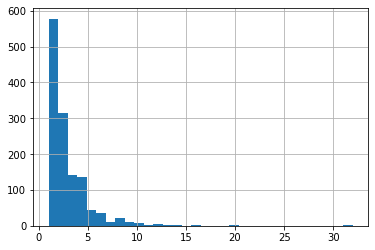

In [33]:
# How many plants have N components?
xwalk.groupby('CAMD_PLANT_ID')['component_id'].nunique().hist(bins=32)

In [34]:
# how many plants have more than 1 component?
xwalk.groupby('CAMD_PLANT_ID')['component_id'].nunique().gt(1).mean()

0.5614567526555387

In [35]:
# how many components are one-to-one combustors to generators?
xwalk.groupby('component_id').size().eq(1).mean()

0.7582080392758515

In [36]:
# how many unit types do components have?
# about 600 plants with 1 subcomponent retired
xwalk.groupby('component_id')['EIA_UNIT_TYPE'].nunique().value_counts()

1    2712
2     545
3       2
Name: EIA_UNIT_TYPE, dtype: int64

#### Heterogeneity of unit types

In [37]:
# distribution of components by unit type combinations
xwalk.groupby('component_id')['EIA_UNIT_TYPE'].agg(lambda x: frozenset(x.values.reshape(-1))).value_counts()

(GT)            1768
(ST)             870
(CA, CT)         538
(CS)              41
(CT)              20
(IC)              12
(ST, GT)           6
(CA, ST, CT)       2
(CA)               1
(CA, GT)           1
Name: EIA_UNIT_TYPE, dtype: int64

#### Heterogeneity of fuel types

In [38]:
# How many types of fuel are in each component?
xwalk.groupby('component_id')['EIA_FUEL_TYPE'].nunique().value_counts()

1    3250
2       8
3       1
Name: EIA_FUEL_TYPE, dtype: int64

In [39]:
# CAMD version
# How many types of fuel are in each component?
xwalk.groupby('component_id')['CAMD_FUEL_TYPE'].nunique().value_counts()

1    3249
2       9
0       1
Name: CAMD_FUEL_TYPE, dtype: int64

In [40]:
# look at most heterogeneous components
xwalk.groupby('component_id').filter(lambda x: x['EIA_FUEL_TYPE'].nunique() == 3)

,component_id,SEQUENCE_NUMBER,CAMD_STATE,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,CAMD_NAMEPLATE_CAPACITY,CAMD_FUEL_TYPE,CAMD_LATITUDE,CAMD_LONGITUDE,CAMD_STATUS,CAMD_STATUS_DATE,CAMD_RETIRE_YEAR,MOD_CAMD_UNIT_ID,MOD_CAMD_GENERATOR_ID,EIA_STATE,EIA_PLANT_NAME,EIA_PLANT_ID,EIA_GENERATOR_ID,EIA_NAMEPLATE_CAPACITY,EIA_BOILER_ID,EIA_UNIT_TYPE,EIA_FUEL_TYPE,EIA_LATITUDE,EIA_LONGITUDE,EIA_RETIRE_YEAR,PLANT_ID_CHANGE_FLAG,MOD_EIA_PLANT_ID,MOD_EIA_BOILER_ID,MOD_EIA_GENERATOR_ID_BOILER,MOD_EIA_GENERATOR_ID_GEN,MATCH_TYPE_GEN,MATCH_TYPE_BOILER
3025,2101,3980.0,PA,Pixelle Specialty Solutions,50397,036,GEN1,6.0,Coal,39.8717,-76.8664,OPR,1988-12-15T00:00:00,0,036,GEN1,PA,Pixelle Specialty Solutions LLC - Spring Grove Facility,50397.0,GEN1,6.0,5PB036,ST,NG,39.870935,-76.868117,0.0,0.0,50397.0,36,1,GEN1,3_1_Generator (generators) match on plant and gen IDs Step 1a: Exact match,"6_1_EnviroAssoc (boilers and generators) match on plant, boiler, and gen IDs Step 2d: Modify IDs..."
3026,2101,3981.0,PA,Pixelle Specialty Solutions,50397,036,GEN2,6.0,Coal,39.8717,-76.8664,OPR,1988-12-15T00:00:00,0,036,GEN2,PA,Pixelle Specialty Solutions LLC - Spring Grove Facility,50397.0,GEN2,5.9,NaN,ST,BIT,39.870935,-76.868117,2016.0,0.0,50397.0,NaN,NaN,GEN2,3_1_Generator (generators) match on plant and gen IDs Step 1a: Exact match,NaN
3027,2101,3984.0,PA,Pixelle Specialty Solutions,50397,036,GEN3,5.1,Coal,39.8717,-76.8664,OPR,1988-12-15T00:00:00,0,036,GEN3,PA,Pixelle Specialty Solutions LLC - Spring Grove Facility,50397.0,GEN3,5.1,5PB036,ST,NG,39.870935,-76.868117,0.0,0.0,50397.0,36,3,GEN3,3_1_Generator (generators) match on plant and gen IDs Step 1a: Exact match,"6_1_EnviroAssoc (boilers and generators) match on plant, boiler, and gen IDs Step 2d: Modify IDs..."
3028,2101,3983.0,PA,Pixelle Specialty Solutions,50397,036,GEN4,7.5,Coal,39.8717,-76.8664,OPR,1988-12-15T00:00:00,0,036,GEN4,PA,Pixelle Specialty Solutions LLC - Spring Grove Facility,50397.0,GEN4,7.5,5PB036,ST,NG,39.870935,-76.868117,0.0,0.0,50397.0,36,4,GEN4,3_1_Generator (generators) match on plant and gen IDs Step 1a: Exact match,"6_1_EnviroAssoc (boilers and generators) match on plant, boiler, and gen IDs Step 2d: Modify IDs..."
3029,2101,3985.0,PA,Pixelle Specialty Solutions,50397,036,GEN5,45.9,Coal,39.8717,-76.8664,OPR,1988-12-15T00:00:00,0,036,GEN5,PA,Pixelle Specialty Solutions LLC - Spring Grove Facility,50397.0,GEN5,45.9,5PB036,ST,BIT,39.870935,-76.868117,0.0,0.0,50397.0,36,5,GEN5,3_1_Generator (generators) match on plant and gen IDs Step 1a: Exact match,"6_1_EnviroAssoc (boilers and generators) match on plant, boiler, and gen IDs Step 2d: Modify IDs..."
3030,2101,3982.0,PA,Pixelle Specialty Solutions,50397,036,GEN6,39.2,Coal,39.8717,-76.8664,OPR,1988-12-15T00:00:00,0,036,GEN6,PA,Pixelle Specialty Solutions LLC - Spring Grove Facility,50397.0,GEN6,39.1,5PB036,ST,BLQ,39.870935,-76.868117,0.0,0.0,50397.0,36,6,GEN6,3_1_Generator (generators) match on plant and gen IDs Step 1a: Exact match,"6_1_EnviroAssoc (boilers and generators) match on plant, boiler, and gen IDs Step 2d: Modify IDs..."
3031,2101,3986.0,PA,Pixelle Specialty Solutions,50397,038,GEN1,6.0,Pipeline Natural Gas,39.8717,-76.8664,OPR,2017-01-05T00:00:00,0,038,GEN1,PA,Pixelle Specialty Solutions LLC - Spring Grove Facility,50397.0,GEN1,6.0,6PB038,ST,NG,39.870935,-76.868117,0.0,0.0,50397.0,38,1,GEN1,3_1_Generator (generators) match on plant and gen IDs Step 1a: Exact match,"6_1_EnviroAssoc (boilers and generators) match on plant, boiler, and gen IDs Step 2d: Modify IDs..."
3032,2101,3989.0,PA,Pixelle Specialty Solutions,50397,039,GEN1,6.0,Pipeline Natural Gas,39.8717,-76.8664,OPR,2016-12-06T00:00:00,0,039,GEN1,PA,Pixelle Specialty Solutions LLC - Spring Grove Facility,50397.0,GEN1,6.0,7PB039,ST,NG,39.870935,-76.868117,0.0,0.0,50397.0,39,1,GEN1,3_1_Generator (generators) match on plant and gen IDs Step 1a: Exact match,"6_1_EnviroAssoc (boilers and generators) match on plant, boiler, and gen IDs Step 2d: Modify IDs..

In [41]:
# what combinations of fuels are present?
xwalk.groupby('component_id')['EIA_FUEL_TYPE'].agg(
    lambda x: frozenset(x.values.reshape(-1))).value_counts()

(NG)              2374
(DFO)              227
(SUB)              203
(BIT)              196
(RC)                90
(KER)               51
(WDS)               23
(LIG)               17
(RFO)               17
(WC)                14
(OG)                12
(BLQ)                9
(PC)                 5
(JF)                 5
(SUN)                3
(NG, BLQ)            2
(BFG)                2
(NG, BIT)            2
(NG, WDS)            1
(NG, BLQ, BIT)       1
(MSW)                1
(NG, BFG)            1
(PC, WDS)            1
(SGC)                1
(SGC, SGP)           1
Name: EIA_FUEL_TYPE, dtype: int64

There are only 9 multi-fuel components, and they look to be industrial facilities using black liquor, blast furnace gas, wood, petcoke, etc. I don't think I need to look into any more detail.

## Aggregate metadata to component level
I'll directly map tech type combinations to {steam, gas turbine, combined cycle, internal combustion}.

For fuel types, I'll use whichever fuel has largest associated nameplate capacity. This could be changed to largest energy production, but that takes more work, so I'll defer for now.

### How different are CAMD vs EIA nameplate capacity?

In [42]:
# sum(nan) -> 0, so set back to nan
epa_cap = (xwalk.groupby(by=["component_id", 'CAMD_UNIT_ID'], as_index=False)
           .first()  # avoid double counting combustors
           .groupby('component_id')['CAMD_NAMEPLATE_CAPACITY']
           .sum()
           .replace(0, np.nan)
           .dropna()
          )

In [43]:
eia_cap = (xwalk.groupby(by=["component_id", 'EIA_GENERATOR_ID'], as_index=False)
           .first()  # avoid double counting generators
           .groupby('component_id')['EIA_NAMEPLATE_CAPACITY']
           .sum()
           .replace(0, np.nan)
           .dropna()
          )

In [44]:
epa_cap.shape, eia_cap.shape

((2866,), (3259,))

In [45]:
xwalk['component_id'].nunique()

3259

In [46]:
caps = pd.concat([epa_cap.rename('CAMD'), eia_cap.rename('EIA')], axis=1)

In [47]:
caps.shape

(3259, 2)

<AxesSubplot:>

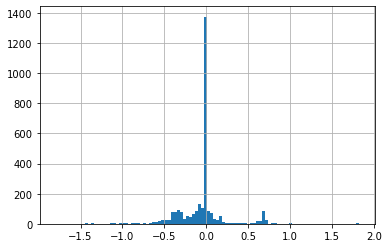

In [48]:
# normalize by the average - will give accurate percentages when epa and eia are close
# (which is when percentages are useful anyway)
(caps['CAMD'] - caps['EIA']).div(caps.mean(axis=1)).hist(bins=100)

In [49]:
# what fraction are exact matches?
(caps['CAMD'] - caps['EIA']).eq(0).mean()

0.3433568579318809

In [50]:
# what fraction of non-missing are exact matches?
(caps['CAMD'] - caps['EIA']).dropna().eq(0).mean()

0.39043963712491275

In [51]:
# what fraction are within 5 percent?
(caps['CAMD'] - caps['EIA']).div(caps.mean(axis=1)).abs().le(0.05).mean()

0.47131021785823873

In [52]:
# what fraction of non-missing are within 5 percent?
(caps['CAMD'] - caps['EIA']).div(caps.mean(axis=1)).dropna().abs().le(0.05).mean()

0.5359385903698535

Nameplate capacities are quite different...

This is not a mapping problem - recall that 75% of components are 1:1 mappings!

I'll just do it both ways and compare results at the end.

### Fuel by highest capacity

In [53]:
fuels = xwalk.groupby(by=['component_id', 'CAMD_FUEL_TYPE'], as_index=False)['CAMD_NAMEPLATE_CAPACITY'].sum()

In [54]:
fuels

,component_id,CAMD_FUEL_TYPE,CAMD_NAMEPLATE_CAPACITY
0,0,Pipeline Natural Gas,153.1
1,1,Pipeline Natural Gas,153.1
2,2,Coal,403.8
3,3,Coal,788.8
4,4,Pipeline Natural Gas,723.8
...,...,...,...
3262,3254,Pipeline Natural Gas,128.0
3263,3255,Pipeline Natural Gas,399.1
3264,3256,Pipeline Natural Gas,399.1
3265,3257,Pipeline Natural Gas,185.0


In [55]:
fuels['max'] = fuels.groupby('component_id')['CAMD_NAMEPLATE_CAPACITY'].transform(np.max)

In [56]:
fuels = fuels.loc[fuels['max'] == fuels['CAMD_NAMEPLATE_CAPACITY'], ['component_id', 'CAMD_FUEL_TYPE']].set_index('component_id')
fuels

,CAMD_FUEL_TYPE
component_id,
0,Pipeline Natural Gas
1,Pipeline Natural Gas
2,Coal
3,Coal
4,Pipeline Natural Gas
...,...
3254,Pipeline Natural Gas
3255,Pipeline Natural Gas
3256,Pipeline Natural Gas


In [57]:
# made a function to do above
# It also handles NaNs, ties, etc
aggs = aggregate_subcomponents(xwalk)

In [58]:
aggs

,EIA_UNIT_TYPE,capacity_CAMD,capacity_EIA,simple_CAMD_FUEL_TYPE_via_capacity,simple_EIA_FUEL_TYPE_via_capacity,simple_EIA_UNIT_TYPE
component_id,,,,,,
0,(ST),153.1,153.1,gas,gas,steam_turbine
1,(ST),153.1,153.1,gas,gas,steam_turbine
2,(ST),403.8,403.7,coal,coal,steam_turbine
3,(ST),788.8,788.8,coal,coal,steam_turbine
4,"(CA, CT)",361.9,535.4,gas,gas,combined_cycle
...,...,...,...,...,...,...
3254,(GT),128.0,121.5,gas,gas,gas_turbine
3255,"(CA, CT)",158.4,399.1,gas,gas,combined_cycle
3256,"(CA, CT)",158.4,399.1,gas,gas,combined_cycle


In [59]:
aggs.dtypes

EIA_UNIT_TYPE                         category
capacity_CAMD                          float64
capacity_EIA                           float64
simple_CAMD_FUEL_TYPE_via_capacity    category
simple_EIA_FUEL_TYPE_via_capacity     category
simple_EIA_UNIT_TYPE                  category
dtype: object

In [60]:
aggs.isna().sum()

EIA_UNIT_TYPE                           0
capacity_CAMD                         393
capacity_EIA                            0
simple_CAMD_FUEL_TYPE_via_capacity    394
simple_EIA_FUEL_TYPE_via_capacity       0
simple_EIA_UNIT_TYPE                    0
dtype: int64

In [61]:
aggs.eq(0).sum()

EIA_UNIT_TYPE                         0
capacity_CAMD                         0
capacity_EIA                          0
simple_CAMD_FUEL_TYPE_via_capacity    0
simple_EIA_FUEL_TYPE_via_capacity     0
simple_EIA_UNIT_TYPE                  0
dtype: int64

In [62]:
# the source of the NaNs above is:
xwalk[['CAMD_NAMEPLATE_CAPACITY', 'EIA_NAMEPLATE_CAPACITY']].isna().sum()

CAMD_NAMEPLATE_CAPACITY    676
EIA_NAMEPLATE_CAPACITY       0
dtype: int64

In [63]:
xwalk[['CAMD_NAMEPLATE_CAPACITY', 'EIA_NAMEPLATE_CAPACITY']].eq(0).sum()

CAMD_NAMEPLATE_CAPACITY    0
EIA_NAMEPLATE_CAPACITY     0
dtype: int64

In [64]:
# how often to EIA and CAMD capacities produce different fuel assignments?
disagree = aggs.dropna()['simple_CAMD_FUEL_TYPE_via_capacity'].ne(aggs.dropna()['simple_EIA_FUEL_TYPE_via_capacity'])
disagree.mean()

0.030366492146596858

In [65]:
pd.options.display.max_rows = 100

In [66]:
aggs.dropna()[disagree].sort_values(by=['simple_EIA_UNIT_TYPE', 'simple_EIA_FUEL_TYPE_via_capacity'])

,EIA_UNIT_TYPE,capacity_CAMD,capacity_EIA,simple_CAMD_FUEL_TYPE_via_capacity,simple_EIA_FUEL_TYPE_via_capacity,simple_EIA_UNIT_TYPE
component_id,,,,,,
363,"(CA, CT)",555.90,804.5,coal,gas,combined_cycle
1584,"(CA, CT)",604.00,627.0,oil,gas,combined_cycle
824,(GT),17.10,17.1,oil,gas,gas_turbine
874,(GT),211.80,195.2,oil,gas,gas_turbine
875,(GT),211.80,195.2,oil,gas,gas_turbine
934,(GT),85.00,85.0,oil,gas,gas_turbine
935,(GT),85.00,85.0,oil,gas,gas_turbine
936,(GT),85.00,85.0,oil,gas,gas_turbine
937,(GT),85.00,85.0,oil,gas,gas_turbine


There were only 9 or 10 multi-fuel plants, so most of these disagreements are from the crosswalk itself.